# 🏦 Banknote Authentication with PyTorch

In this notebook, we'll build a **neural network** to classify whether a banknote is **authentic or fake** based on its physical features.

## What You'll Learn:
- How to load and prepare data for machine learning
- How to create a custom PyTorch Dataset
- How to build a simple neural network
- How to train and evaluate the model
- How to make predictions and save your model

---

In [46]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Import Required Libraries

Before we start, we need to import the tools we'll use:

- **pandas**: A library for working with tabular data (like spreadsheets)
- **torch**: PyTorch - our deep learning framework
- **DataLoader & Dataset**: PyTorch utilities to efficiently load and batch our data
- **nn (neural network)**: PyTorch module containing building blocks for neural networks

In [47]:
torch.__version__

'2.9.1'

## Step 2: Check PyTorch Version

It's good practice to verify which version of PyTorch you're using. This helps with debugging and ensuring compatibility.

In [48]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'

device

'mps'

## Step 3: Select the Compute Device

Neural networks can run on different hardware:
- **CPU**: The standard processor in your computer (slower for deep learning)
- **CUDA**: NVIDIA GPU acceleration (much faster!)
- **MPS**: Apple Silicon GPU acceleration (for M1/M2/M3 Macs)

This code automatically picks the best available device. Training on GPU can be **10-100x faster** than CPU!

In [49]:
df = pd.read_csv('data/banknotes.csv')
df.head()

,variance,skewness,curtosis,entropy,class
0,-0.89569,3.00250,-3.606700,-3.44570,1
1,3.47690,-0.15314,2.530000,2.44950,0
2,3.91020,6.06500,-2.453400,-0.68234,0
3,0.60731,3.95440,-4.772000,-4.48530,1
4,2.37180,7.49080,0.015989,-1.74140,0


In [50]:
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


### Exploratory Data Analysis: Statistical Summary

The `describe()` function gives us key statistics for each column:

| Statistic | What It Tells Us |
|-----------|------------------|
| **count** | Number of non-missing values (1372 banknotes in our dataset) |
| **mean** | The average value - useful for understanding the "center" of your data |
| **std** | Standard deviation - how spread out the values are from the mean |
| **min/max** | The smallest and largest values - helps spot outliers |
| **25%, 50%, 75%** | Quartiles - 50% is the median (middle value) |

💡 **What to look for:**
- Are the ranges similar across features? If not, you might need to normalize/scale the data
- Is the mean close to the median (50%)? If not, the data might be skewed
- For the `class` column: the mean tells us the proportion of fake banknotes (closer to 0 = mostly real, closer to 1 = mostly fake)

Correlation:
class       1.000000
curtosis    0.155883
entropy    -0.023424
skewness   -0.444688
variance   -0.724843
Name: class, dtype: float64


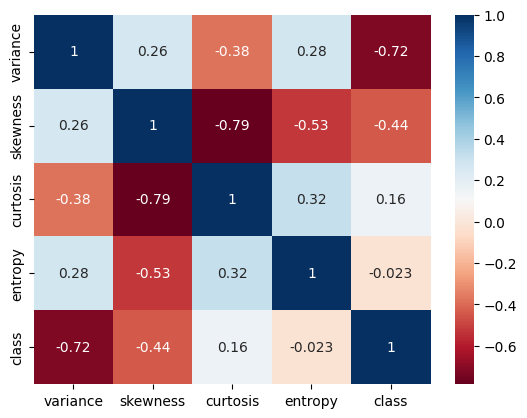

In [51]:
# Check correlation
print('Correlation:')
print(df.corr()['class'].sort_values(ascending=False))
sns.heatmap(df.corr(), annot=True, cmap="RdBu")
plt.show()

### Exploratory Data Analysis: Correlation Heatmap 🔥

**Correlation** measures how strongly two variables are related (values from -1 to +1):

| Correlation | Meaning |
|-------------|---------|
| **+1** | Perfect positive correlation (when one goes up, the other goes up) |
| **0** | No correlation (variables are independent) |
| **-1** | Perfect negative correlation (when one goes up, the other goes down) |

### Reading the Heatmap:
- **Colors**: Red = negative correlation, Blue = positive correlation, White = no correlation
- **Numbers**: The actual correlation coefficient (annotated in each cell)
- **Diagonal**: Always 1.0 (every variable correlates perfectly with itself!)

### Why This Matters for Our Model:
Look at the `class` row/column to see which features are most predictive:
- **High absolute correlation** with `class` = that feature is useful for prediction
- **Variance** typically has the strongest correlation with authenticity
- Features with **low correlation to class** might be less useful (but neural networks can find complex patterns!)

⚠️ **Warning**: High correlation between features (multicollinearity) can sometimes cause issues, but neural networks handle this well.

## Step 4: Load the Dataset

We're using the **Banknote Authentication Dataset**. Each row contains measurements extracted from images of banknotes:

| Feature | Description |
|---------|-------------|
| variance | Variance of the image (how spread out pixel values are) |
| skewness | Skewness of the image (asymmetry of pixel distribution) |
| curtosis | Kurtosis of the image (how peaked the distribution is) |
| entropy | Entropy of the image (randomness/information content) |
| **class** | 0 = authentic, 1 = fake |

The `head()` function shows us the first 5 rows to preview our data.

In [52]:
X = df.drop('class', axis=1).values
y = df['class'].values

# we could also use sklearn.model_selection.train_test_split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1097, 4), (275, 4), (1097,), (275,))

## Step 5: Split Data into Features and Labels

In machine learning, we separate our data into:
- **X (Features)**: The input data the model learns from (4 measurements per banknote)
- **y (Labels)**: The answers we want to predict (0 = real, 1 = fake)

### Train/Test Split
We split our data into two parts:
- **Training set (80%)**: Used to teach the model
- **Test set (20%)**: Used to evaluate how well the model learned (data it has never seen!)

This prevents **overfitting** - where a model memorizes training data but fails on new data.

In [53]:
class BanknoteDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = BanknoteDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
test_dataset = BanknoteDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32).unsqueeze(1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Step 6: Create a Custom PyTorch Dataset

PyTorch uses **Dataset** and **DataLoader** to efficiently manage data:

### Dataset Class
A custom Dataset needs three methods:
- `__init__`: Store the data
- `__len__`: Return how many samples we have
- `__getitem__`: Return a single sample by index

### DataLoader
The DataLoader wraps our Dataset and provides:
- **Batching**: Groups samples together (batch_size=32 means 32 samples at a time)
- **Shuffling**: Randomizes order each epoch (helps the model learn better)
- **Parallel loading**: Loads data efficiently

### Why Tensors?
We convert our data to **tensors** - PyTorch's version of arrays that can run on GPU and support automatic differentiation (needed for training).

In [54]:
class BanknoteClassifier(nn.Module):
    def __init__(self):
        super(BanknoteClassifier, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

model = BanknoteClassifier()
model.to(device)

BanknoteClassifier(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

## Step 7: Build the Neural Network

Now for the exciting part - creating our neural network! 🧠

### Architecture
```
Input (4 features) → Hidden Layer (10 neurons) → ReLU → Output (1 neuron)
```

### Components Explained:
- **`nn.Linear(4, 10)`**: A fully connected layer that takes 4 inputs and produces 10 outputs
- **`nn.Linear(10, 1)`**: Takes 10 inputs and produces 1 output (our prediction)
- **`torch.relu()`**: Activation function that adds non-linearity (without it, the network would just be a linear function!)

### What is ReLU?
ReLU (Rectified Linear Unit) is simple: `max(0, x)`. It keeps positive values and sets negative values to zero. This helps the network learn complex patterns.

### Moving to Device
`model.to(device)` moves the model to our GPU (if available) for faster computation.

In [55]:
# print model params
for name, param in model.named_parameters():
    print(name, param.shape)

# total number of params
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

fc1.weight torch.Size([10, 4])
fc1.bias torch.Size([10])
fc2.weight torch.Size([1, 10])
fc2.bias torch.Size([1])


61

## Step 8: Inspect Model Parameters

Let's see what our model has learned (or will learn)!

**Parameters** are the weights and biases that the model adjusts during training:
- `fc1.weight`: 10×4 = 40 parameters (connections from 4 inputs to 10 hidden neurons)
- `fc1.bias`: 10 parameters (one bias per hidden neuron)
- `fc2.weight`: 1×10 = 10 parameters (connections from 10 hidden to 1 output)
- `fc2.bias`: 1 parameter

**Total: 61 trainable parameters** - these are the numbers the optimizer will tune!

In [56]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    train_loss = 0.0
    test_loss = 0.0
    total_correct = 0

    for batch in train_loader:
        model.train()
        X, y = batch
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = criterion(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    for batch in test_loader:
        model.eval()
        with torch.inference_mode():
            X, y = batch
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            loss = criterion(y_logits, y)
            test_loss += loss.item()

            y_prob = torch.sigmoid(y_logits)
            y_pred = torch.round(y_prob)

            correct = (y_pred == y).sum().item()
            total_correct += correct

    accuracy = total_correct / len(test_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}, Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {accuracy}")


Epoch 1, Loss: 0.5820654324122838, Test Loss: 0.5337619913948907, Test Accuracy: 0.7454545454545455
Epoch 2, Loss: 0.4995594373771122, Test Loss: 0.475076652235455, Test Accuracy: 0.8036363636363636
Epoch 3, Loss: 0.440601076398577, Test Loss: 0.42830490072568256, Test Accuracy: 0.8327272727272728
Epoch 4, Loss: 0.3919990411826542, Test Loss: 0.3847212294737498, Test Accuracy: 0.8872727272727273
Epoch 5, Loss: 0.34950610314096725, Test Loss: 0.34349369671609664, Test Accuracy: 0.9163636363636364
Epoch 6, Loss: 0.30593135271753585, Test Loss: 0.30528082119094, Test Accuracy: 0.9309090909090909
Epoch 7, Loss: 0.26870501382010326, Test Loss: 0.26935771107673645, Test Accuracy: 0.9418181818181818
Epoch 8, Loss: 0.23820695877075196, Test Loss: 0.23819767269823286, Test Accuracy: 0.9490909090909091
Epoch 9, Loss: 0.2068233915737697, Test Loss: 0.21037297116385567, Test Accuracy: 0.9490909090909091
Epoch 10, Loss: 0.18196195108549937, Test Loss: 0.18656627337137857, Test Accuracy: 0.96
Epoch 

## Step 9: Train the Model 🏋️

This is where the magic happens! Let's break down the training loop:

### Loss Function: BCEWithLogitsLoss
- **BCE** = Binary Cross Entropy (for binary classification: real vs fake)
- **WithLogits** = It applies sigmoid internally (more numerically stable)
- Measures how wrong our predictions are (lower = better)

### Optimizer: Adam
- Adam is a popular optimization algorithm
- **Learning rate (lr=0.001)**: How big of steps to take when updating weights
- Automatically adjusts the model's parameters to minimize loss

### Training Loop Breakdown:
1. **Forward pass**: Feed data through the model to get predictions
2. **Calculate loss**: Compare predictions to actual labels
3. **Backward pass** (`loss.backward()`): Calculate gradients (how to adjust each parameter)
4. **Update weights** (`optimizer.step()`): Apply the adjustments
5. **Evaluate**: Test on unseen data to check real performance

### Key Concepts:
- **Epoch**: One complete pass through all training data
- **model.train()**: Enable training mode (activates dropout, batch norm, etc.)
- **model.eval()**: Enable evaluation mode (disables training-specific behaviors)
- **torch.inference_mode()**: Disables gradient tracking for faster evaluation

In [57]:
import random

model.eval()
with torch.inference_mode():
    X, y = test_dataset[random.randint(0, len(test_dataset))]
    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    y_prob = torch.sigmoid(y_logits)
    y_pred = torch.round(y_prob)
    print("y_pred:", y_pred, "y_true:", y)

y_pred: tensor([0.], device='mps:0') y_true: tensor([0.], device='mps:0')


## Step 10: Make a Prediction 🔮

Let's test our trained model on a random sample from the test set!

### Understanding the Output:
1. **Logits** (`y_logits`): Raw model output (can be any number)
2. **Probability** (`y_prob`): Sigmoid converts logits to 0-1 range (probability of being fake)
3. **Prediction** (`y_pred`): Round to get final class (0 or 1)

### Sigmoid Function
Sigmoid "squashes" any number into the range [0, 1]:
- Large positive → close to 1
- Large negative → close to 0
- Zero → 0.5

This gives us a probability interpretation: "How confident is the model that this is a fake banknote?"

In [76]:
import os
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/banknote_classifier.pth')

## Step 11: Save the Model 💾

We save the trained model so we can use it later without retraining!

### What's Being Saved?
- `model.state_dict()`: A dictionary containing all the learned parameters (weights and biases)
- This is the recommended way to save PyTorch models

### Loading Later
To use this model again:
```python
model = BanknoteClassifier()
model.load_state_dict(torch.load('models/banknote_classifier.pth'))
model.eval()  # Set to evaluation mode
```

---

## 🎉 Congratulations!
You've successfully built, trained, and saved a neural network for banknote classification!

Evaluate batch: 100%|██████████| 9/9 [00:00<00:00, 4726.27it/s]


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       165
         1.0       0.98      1.00      0.99       110

    accuracy                           0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275



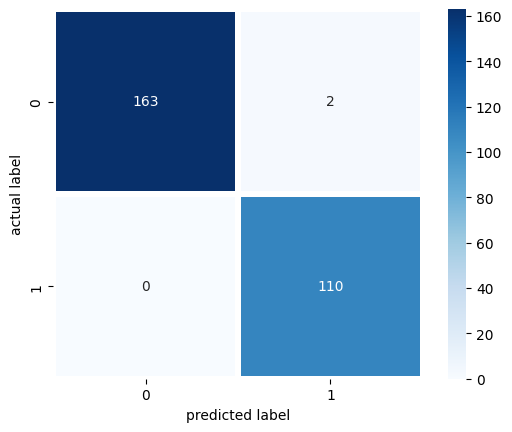

In [75]:
from sklearn import metrics
from tqdm import tqdm

state_dict = torch.load('models/banknote_classifier.pth')
model = BanknoteClassifier()
model.load_state_dict(state_dict)
model.eval()

y_true = []
y_predicted = []

with torch.inference_mode():
    for batch in tqdm(test_loader, desc="Evaluate batch"):
        X_eval, y_eval = batch
        logits = model(X_eval)
        y_probs = torch.sigmoid(logits)
        y_preds = torch.round(y_probs)
        y_predicted.extend(y_preds.squeeze().tolist())
        y_true.extend(y_eval.squeeze().tolist())


# Calculate F1 Score and Recall
print()
print('Classification Report:')
print(metrics.classification_report(y_true, y_predicted))

# Confusion matrix
cm_knn = metrics.confusion_matrix(y_true, y_predicted)
sns.heatmap(cm_knn, annot=True, fmt=".0f", linewidths=3, square=True, cmap='Blues', color="#cd1076")
plt.ylabel('actual label')
plt.xlabel('predicted label')
plt.show()

## Step 12: Evaluate the Model with Metrics 📊

Now let's properly evaluate our saved model using industry-standard metrics!

### Loading the Saved Model
We load the model from disk using `torch.load()` and set it to evaluation mode with `model.eval()`.

### Classification Report Metrics Explained:

| Metric | What It Means | Formula |
|--------|---------------|---------|
| **Precision** | Of all predicted positives, how many were actually positive? | TP / (TP + FP) |
| **Recall** | Of all actual positives, how many did we correctly identify? | TP / (TP + FN) |
| **F1-Score** | Harmonic mean of precision and recall (balanced measure) | 2 × (Precision × Recall) / (Precision + Recall) |
| **Support** | Number of actual occurrences of each class in the test set | — |
| **Accuracy** | Overall percentage of correct predictions | (TP + TN) / Total |

> **TP** = True Positive, **FP** = False Positive, **FN** = False Negative, **TN** = True Negative

### Confusion Matrix Explained:

The confusion matrix is a table showing prediction results:

```
                 Predicted
                 0    |    1
Actual  0    [  TN   |   FP  ]    ← Actual Negatives (Real banknotes)
        1    [  FN   |   TP  ]    ← Actual Positives (Fake banknotes)
```

**How to read it:**
- **Diagonal (TN, TP)**: Correct predictions ✅
- **Off-diagonal (FP, FN)**: Errors ❌
- **Top-left (TN)**: Real banknotes correctly identified as real
- **Bottom-right (TP)**: Fake banknotes correctly identified as fake
- **Top-right (FP)**: Real banknotes incorrectly flagged as fake (False Alarm!)
- **Bottom-left (FN)**: Fake banknotes missed and classified as real (Dangerous!)

💡 **For fraud detection**, we care more about **recall** (catching all fakes) even if it means some false alarms!